In [1]:
# Cell 1: Install required packages
!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
!pip install -q opencv-python matplotlib pillow numpy
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00


In [2]:
# Cell 2: Download SAM 2 checkpoint
import os
import urllib.request

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Download SAM 2 checkpoint (using the smaller hiera_small model for faster inference)
checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
checkpoint_path = "checkpoints/sam2_hiera_small.pt"

if not os.path.exists(checkpoint_path):
    print("Downloading SAM 2 checkpoint...")
    urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
    print("Download complete!")
else:
    print("Checkpoint already exists!")

Download complete!


In [3]:
# Cell 3: Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import clip
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Cell 4: Initialize models
print("Loading models...")

# Initialize CLIP for text-to-region conversion
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
print(f"CLIP loaded on {device}")


Loading models...


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 117MiB/s]


CLIP loaded on cuda


In [4]:
# Initialize SAM 2
sam2_checkpoint = "checkpoints/sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
print("SAM 2 loaded successfully!")


SAM 2 loaded successfully!


In [6]:
# Helper functions for text-to-region conversion using CLIP
def get_text_features(text_prompt, model, device):
    """Convert text prompt to CLIP features"""
    text_tokens = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

def generate_grid_points(image_shape, grid_size=32):
    """Generate a grid of points across the image"""
    h, w = image_shape[:2]
    x_coords = np.linspace(0, w-1, grid_size)
    y_coords = np.linspace(0, h-1, grid_size)
    xx, yy = np.meshgrid(x_coords, y_coords)
    points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    return points

def get_patch_similarity(image, points, text_features, clip_model, preprocess, device, patch_size=64):
    """Calculate similarity between image patches and text prompt"""
    similarities = []

    for point in points:
        x, y = int(point[0]), int(point[1])

        # Extract patch around point
        x1 = max(0, x - patch_size // 2)
        y1 = max(0, y - patch_size // 2)
        x2 = min(image.shape[1], x + patch_size // 2)
        y2 = min(image.shape[0], y + patch_size // 2)

        patch = image[y1:y2, x1:x2]

        # Handle edge cases where patch is too small
        if patch.shape[0] < 10 or patch.shape[1] < 10:
            similarities.append(0.0)
            continue

        # Convert patch to PIL and preprocess for CLIP
        patch_pil = Image.fromarray(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        patch_input = preprocess(patch_pil).unsqueeze(0).to(device)

        # Get image features
        with torch.no_grad():
            image_features = clip_model.encode_image(patch_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Calculate similarity
        similarity = (image_features @ text_features.T).item()
        similarities.append(similarity)

    return np.array(similarities)

def text_to_points(image, text_prompt, clip_model, preprocess, device, top_k=5):
    """Convert text prompt to point prompts using CLIP"""
    print(f"Converting text prompt '{text_prompt}' to region seeds...")

    # Get text features
    text_features = get_text_features(text_prompt, clip_model, device)

    # Generate grid points
    grid_points = generate_grid_points(image.shape, grid_size=24)

    # Calculate similarities
    similarities = get_patch_similarity(image, grid_points, text_features,
                                       clip_model, preprocess, device)

    # Get top-k points with highest similarity
    top_indices = np.argsort(similarities)[-top_k:]
    selected_points = grid_points[top_indices]
    selected_scores = similarities[top_indices]

    print(f"Selected {len(selected_points)} point prompts")
    print(f"Similarity scores: {selected_scores}")

    return selected_points, selected_scores

In [13]:
# Cell 6: Main segmentation function
def segment_with_text_prompt(image_path, text_prompt, output_path="segmentation_result.png"):
    """
    Main function: Load image, convert text to seeds, run SAM 2, display results

    Args:
        image_path: Path to input image
        text_prompt: Text description of object to segment (e.g., "a cat", "person", "car")
        output_path: Path to save output visualization
    """
    # Load image
    print(f"\nLoading image: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image shape: {image_rgb.shape}")

    # Convert text prompt to point seeds using CLIP
    point_coords, similarity_scores = text_to_points(
        image, text_prompt, clip_model, preprocess, device, top_k=10
    )

    # Set point labels (1 = foreground)
    point_labels = np.ones(len(point_coords), dtype=np.int32)

    # Run SAM 2
    print("\nRunning SAM 2 segmentation...")
    predictor.set_image(image_rgb)

    masks, scores, logits = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True
    )

    # Select best mask
    best_mask_idx = np.argmax(scores)
    best_mask = masks[best_mask_idx]
    best_score = scores[best_mask_idx]

    print(f"Segmentation complete! Best mask score: {best_score:.3f}")

    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Image with point prompts
    axes[1].imshow(image_rgb)
    axes[1].scatter(point_coords[:, 0], point_coords[:, 1],
                   c='red', s=100, marker='*', edgecolors='white', linewidths=2)
    axes[1].set_title(f"Point Seeds from: '{text_prompt}'", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Mask overlay
    axes[2].imshow(image_rgb)
    mask_overlay = np.zeros_like(image_rgb)
    mask_overlay[best_mask.astype(bool)] = [0, 255, 0]  # Green mask
    axes[2].imshow(mask_overlay, alpha=0.5)
    axes[2].set_title(f"SAM 2 Segmentation (Score: {best_score:.3f})",
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\nResult saved to: {output_path}")
    plt.show()

    return best_mask, best_score, point_coords

Please upload an image file...


Saving animal-cat-adorable-20787.jpg to animal-cat-adorable-20787 (4).jpg

Uploaded: animal-cat-adorable-20787 (4).jpg

TEXT-DRIVEN SEGMENTATION PIPELINE

Loading image: animal-cat-adorable-20787 (4).jpg
Image shape: (2304, 3456, 3)
Converting text prompt 'a cat' to region seeds...
Selected 10 point prompts
Similarity scores: [0.24841309 0.25       0.25146484 0.25244141 0.25268555 0.25317383
 0.25341797 0.25341797 0.26025391 0.26123047]

Running SAM 2 segmentation...
Segmentation complete! Best mask score: 0.922

Result saved to: q2_segmentation_result.png


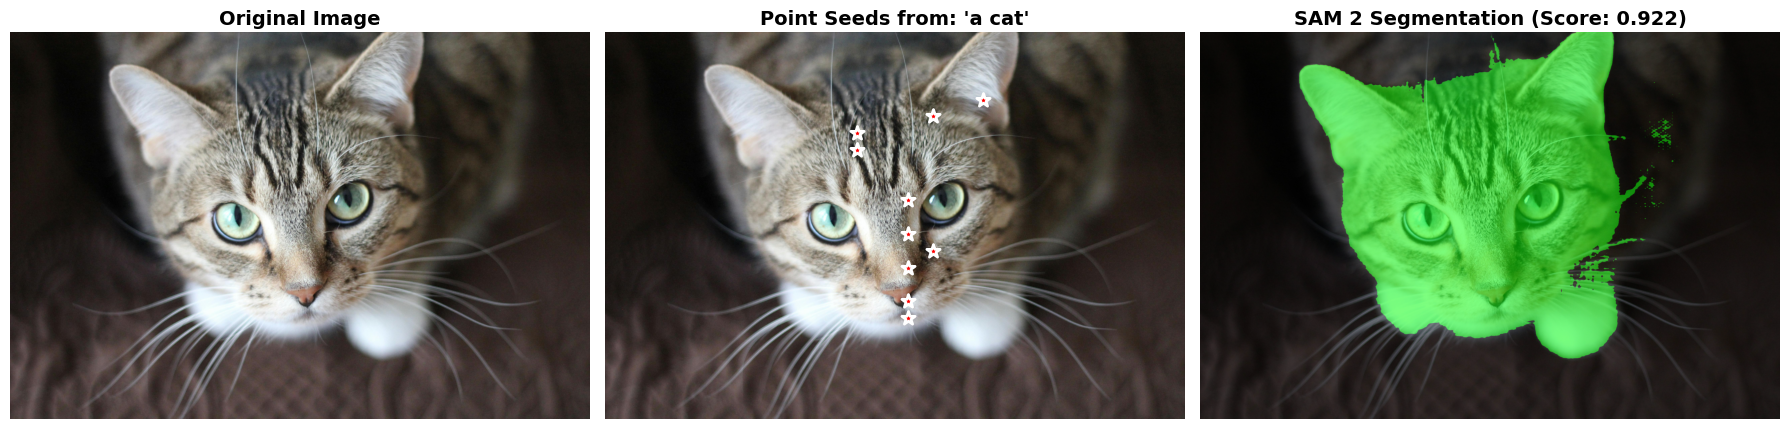


RESULTS:
  - Segmentation Score: 0.922
  - Number of seed points: 10
  - Mask shape: (2304, 3456)
  - Segmented pixels: 2585493.0 (32.5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Cell 7: Upload and segment your image
from google.colab import files

print("Please upload an image file...")
uploaded = files.upload()

# Get the uploaded filename
image_filename = list(uploaded.keys())[0]
print(f"\nUploaded: {image_filename}")

# Cell 8: Run segmentation with your text prompt
# Modify the text_prompt to describe the object you want to segment
text_prompt = "a cat"  # Change this to your desired object (e.g., "a cat", "a car", "a dog")

print(f"\n{'='*60}")
print(f"TEXT-DRIVEN SEGMENTATION PIPELINE")
print(f"{'='*60}")

mask, score, points = segment_with_text_prompt(
    image_path=image_filename,
    text_prompt=text_prompt,
    output_path="q2_segmentation_result.png"
)

print(f"\n{'='*60}")
print(f"RESULTS:")
print(f"  - Segmentation Score: {score:.3f}")
print(f"  - Number of seed points: {len(points)}")
print(f"  - Mask shape: {mask.shape}")
print(f"  - Segmented pixels: {np.sum(mask)} ({100*np.sum(mask)/mask.size:.1f}%)")
print(f"{'='*60}")

# Cell 9: Download the result
files.download("q2_segmentation_result.png")